## 1. Import Libraries
### Importação de bibliotecas necessárias

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Configuração de estilo para os gráficos
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

## 2. Load the data
### Carregamento dos dados

In [208]:
df = pd.read_csv('./PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## 3. Preprocess Data
### Pré-processamento dos dados

In [209]:
# Converter a coluna 'Datetime' para o formato datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extrair componentes de data e hora
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['Year'] = df['Datetime'].dt.year
df['Weekday'] = df['Datetime'].dt.dayofweek
df['DayOfYear'] = df['Datetime'].dt.dayofyear
df['Quarter'] = df['Datetime'].dt.quarter
df['IsWeekend'] = df['Weekday'] >= 5

# Setar 'Datetime' como índice e ordenar os dados
df = df.set_index('Datetime')
df = df.sort_index()

### Adicionar médias móveis e lags para o consumo de energia

In [210]:
df['rolling_mean_3h'] = df['PJME_MW'].rolling(window=3).mean().shift(1)
df['rolling_mean_6h'] = df['PJME_MW'].rolling(window=6).mean().shift(1)
df['lag_1h'] = df['PJME_MW'].shift(1)

# Remover valores nulos resultantes das operações de rolling e shifting
df = df.dropna()

### Visualização do uso de energia

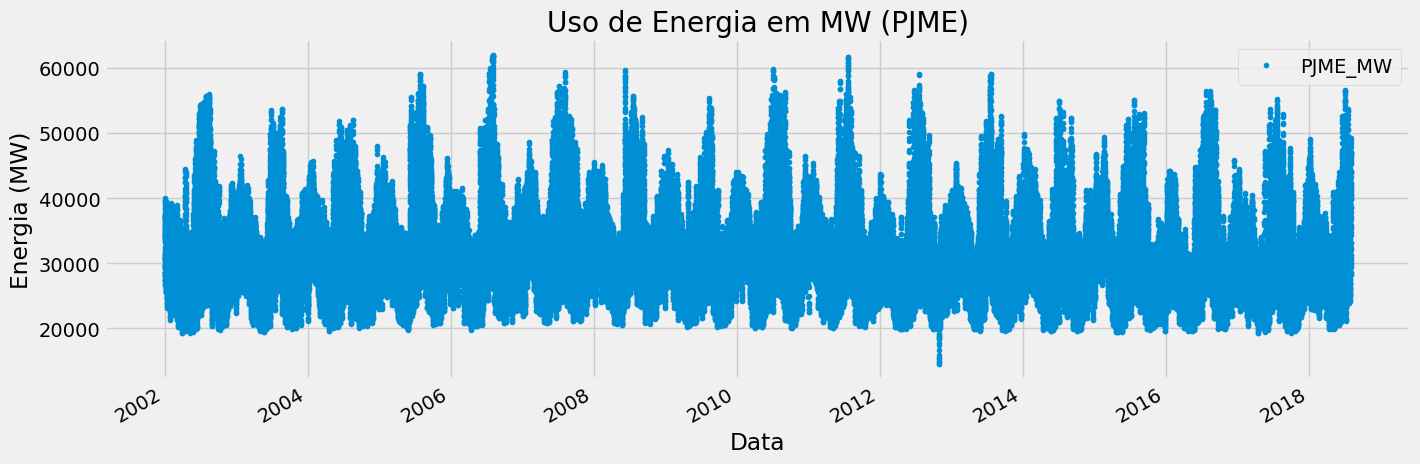

In [211]:
df.plot(y='PJME_MW', style='.', figsize=(15, 5), color=color_palette[0], title='Uso de Energia em MW (PJME)')
plt.xlabel('Data')
plt.ylabel('Energia (MW)')
plt.show()

## 4. Exploratory Data Analysis (EDA)
### Análise Exploratória dos Dados

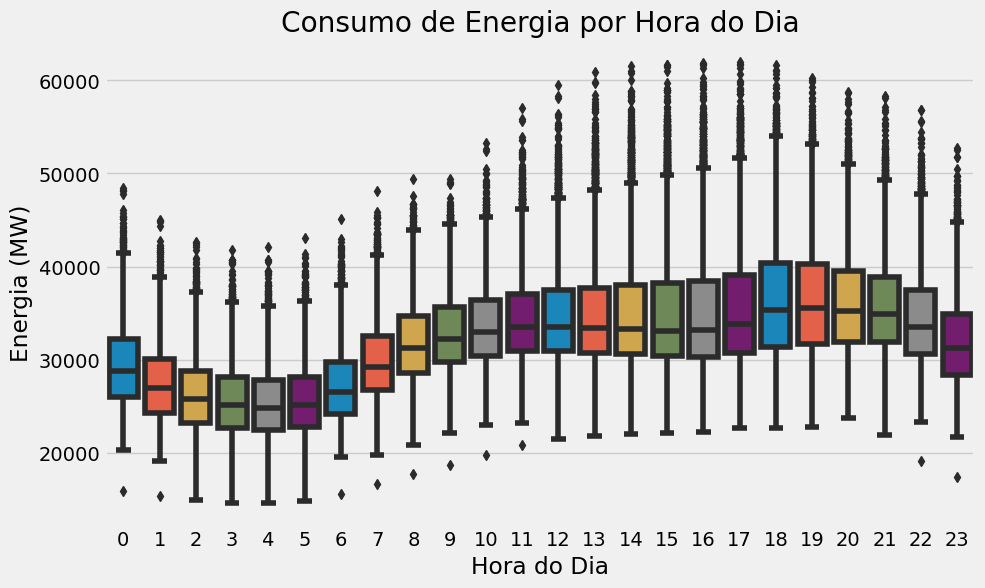

" # Visualizar padrões de consumo para cada dia da semana\nplt.figure(figsize=(10, 6))\nsns.boxplot(x='Weekday', y='PJME_MW', data=df)\nplt.title('Consumo de Energia por Dia da Semana')\nplt.xlabel('Dia da Semana')\nplt.ylabel('Energia (MW)')\nplt.show()\n\n# Visualizar padrões de consumo para cada mês do ano\nplt.figure(figsize=(10, 6))\nsns.boxplot(x='Month', y='PJME_MW', data=df)\nplt.title('Consumo de Energia por Mês do Ano')\nplt.xlabel('Mês')\nplt.ylabel('Energia (MW)')\nplt.show()\n\n# Visualizar padrões de consumo para cada trimestre do ano\nplt.figure(figsize=(10, 6))\nsns.boxplot(x='Quarter', y='PJME_MW', data=df)\nplt.title('Consumo de Energia por Trimestre do Ano')\nplt.xlabel('Trimestre')\nplt.ylabel('Energia (MW)')\nplt.show() "

In [212]:
# Visualizar padrões de consumo de energia para cada hora do dia
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hour', y='PJME_MW', data=df, palette=color_palette)
plt.title('Consumo de Energia por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Energia (MW)')
plt.show()

''' # Visualizar padrões de consumo para cada dia da semana
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weekday', y='PJME_MW', data=df)
plt.title('Consumo de Energia por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Energia (MW)')
plt.show()

# Visualizar padrões de consumo para cada mês do ano
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='PJME_MW', data=df)
plt.title('Consumo de Energia por Mês do Ano')
plt.xlabel('Mês')
plt.ylabel('Energia (MW)')
plt.show()

# Visualizar padrões de consumo para cada trimestre do ano
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quarter', y='PJME_MW', data=df)
plt.title('Consumo de Energia por Trimestre do Ano')
plt.xlabel('Trimestre')
plt.ylabel('Energia (MW)')
plt.show() '''

## 5. Modelagem e Previsão
### Criação de nova variável categórica para alto consumo

In [213]:
threshold = df['PJME_MW'].quantile(0.95)
df['HighConsumption'] = df['PJME_MW'].apply(lambda x: 1 if x >= threshold else 0)

### Divisão dos dados em conjuntos de treino e teste utilizando TimeSeriesSplit

In [214]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

features = ['Hour', 'Day', 'Month', 'Weekday', 'DayOfYear', 'Quarter', 'IsWeekend',
            'rolling_mean_3h', 'rolling_mean_6h', 'lag_1h']
X = df[features]
y_class  = df['HighConsumption'] # Para modelo de classificação de alto consumo
y_forecast = df['PJME_MW'] # Para previsão de consumo

tscv = TimeSeriesSplit(n_splits=5)
model_class = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)

accuracies = []
reports = []

for train_index, text_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[text_index]
    y_train_class, y_test_class = y_class.iloc[train_index], y_class.iloc[text_index]
    
    model_class.fit(X_train, y_train_class)
    y_pred_class = model_class.predict(X_test)
    
    accuracy = accuracy_score(y_test_class, y_pred_class)
    report = classification_report(y_test_class, y_pred_class, output_dict=True)
    
    accuracies.append(accuracy)
    reports.append(report)
    
avg_accuracy = sum(accuracies) / len(accuracies)
print(f'Average Accuracy: {avg_accuracy:.4f}')

precision, recall, f1, _ = precision_recall_fscore_support(y_test_class, y_pred_class, average='binary')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Average Accuracy: 0.9958
Precision: 0.9619
Recall: 0.9409
F1-score: 0.9513


### Visualização dos sets de Teste e Treino

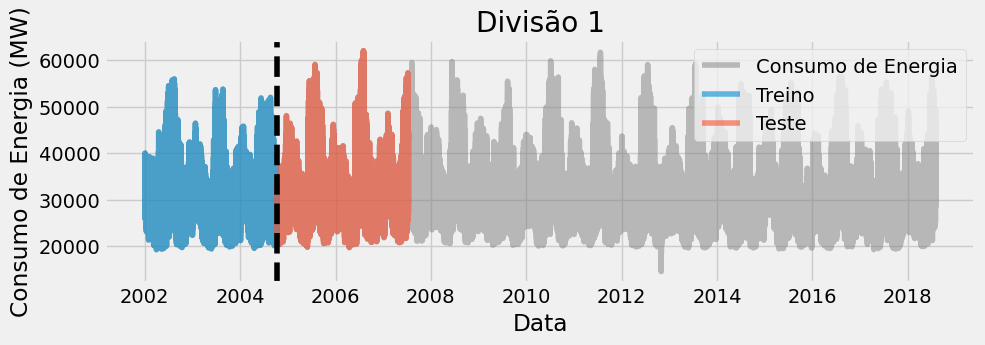

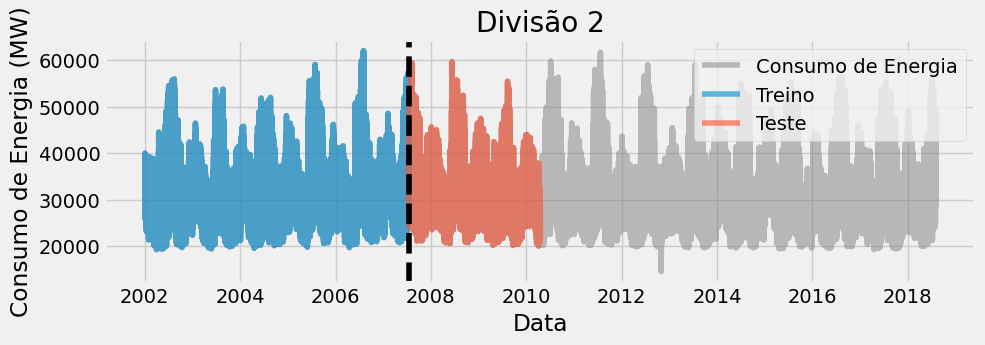

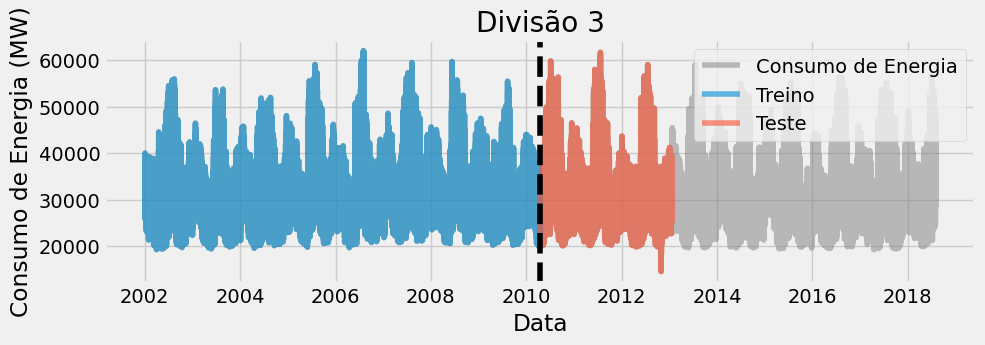

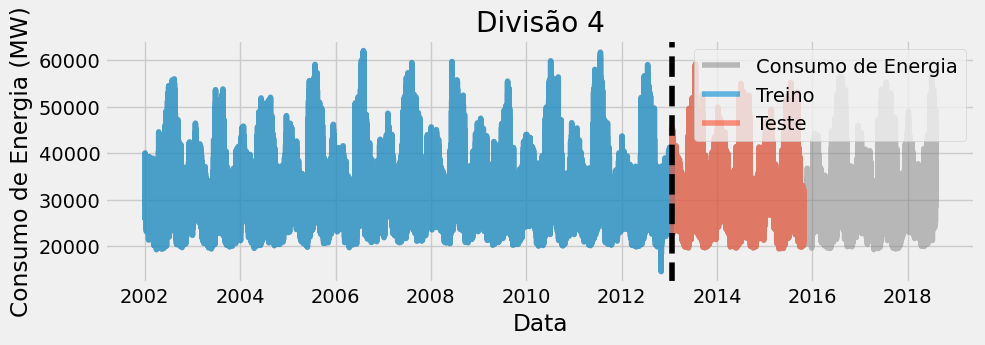

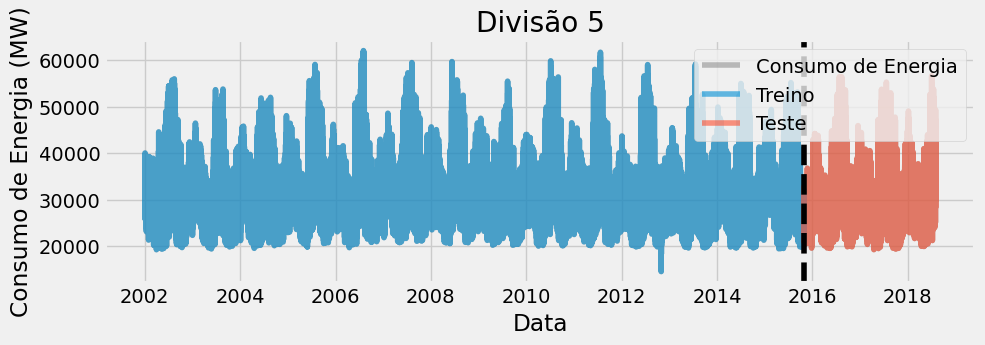

In [215]:
def plot_splits(X, splits, data):
    for i, (train_index, test_index) in enumerate(splits.split(X)):
        plt.figure(figsize=(10, 3))
        plt.plot(data.index, data['PJME_MW'], label='Consumo de Energia', color='grey', alpha=0.5)
        
        # Obter os dados de treino e teste
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Plotar os conjuntos de treino e teste
        plt.plot(train_data.index, train_data['PJME_MW'], label='Treino', color=color_palette[0], alpha=0.6)
        plt.plot(test_data.index, test_data['PJME_MW'], label='Teste', color=color_palette[1], alpha=0.6)
        
        # Plotar a linha de divisão
        plt.axvline(test_data.index[0], color='k', linestyle='--')
        
        plt.title(f'Divisão {i+1}')
        plt.xlabel('Data')
        plt.ylabel('Consumo de Energia (MW)')
        plt.legend()
        plt.show()

# Chamar a função plot_splits com os dados apropriados
plot_splits(X, tscv, df)


### Avaliação do Modelo de Previsão

In [216]:
from sklearn.metrics import mean_squared_error

model_forecast = xgb.XGBRegressor(n_estimators=100, max_depth=10, random_state=42)

forecast_mses = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_forecast, y_test_forecast  = y_forecast.iloc[train_index], y_forecast.iloc[test_index]

    model_forecast.fit(X_train, y_train_forecast)
    y_pred_forecast  = model_forecast.predict(X_test)
    
    forecast_mse = mean_squared_error(y_test_forecast, y_pred_forecast)
    forecast_mses.append(forecast_mse)

avg_forecast_mse = np.mean(forecast_mses)
avg_forecast_rmse = np.sqrt(avg_forecast_mse)
avg_forecast_relative_error = avg_forecast_rmse / df['PJME_MW'].mean()

print(f"Relative Error: {avg_forecast_relative_error:.4f}")

Relative Error: 0.0121


### Avaliação final no último conjunto de teste

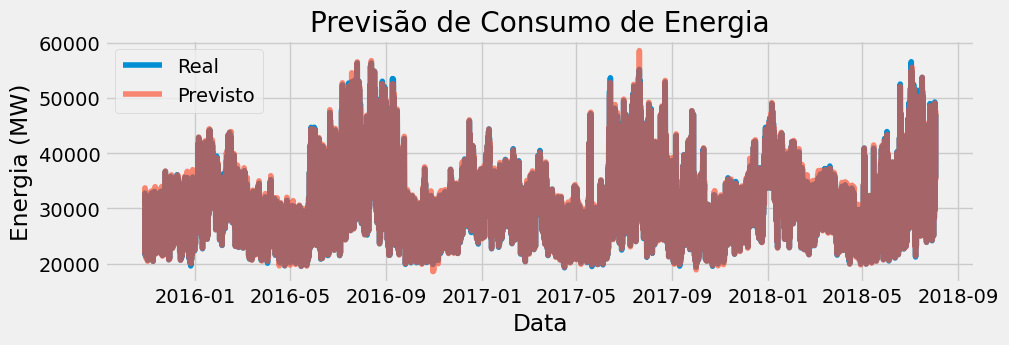

In [217]:

y_pred_final_forecast = model_forecast.predict(X_test)

plt.figure(figsize=(10, 3))
plt.plot(y_test_forecast.index, y_test_forecast, label='Real')
plt.plot(y_test_forecast.index, y_pred_final_forecast, label='Previsto', alpha=0.66)
plt.title('Previsão de Consumo de Energia')
plt.xlabel('Data')
plt.ylabel('Energia (MW)')
plt.legend()
plt.show()


### Avaliação em um período específico

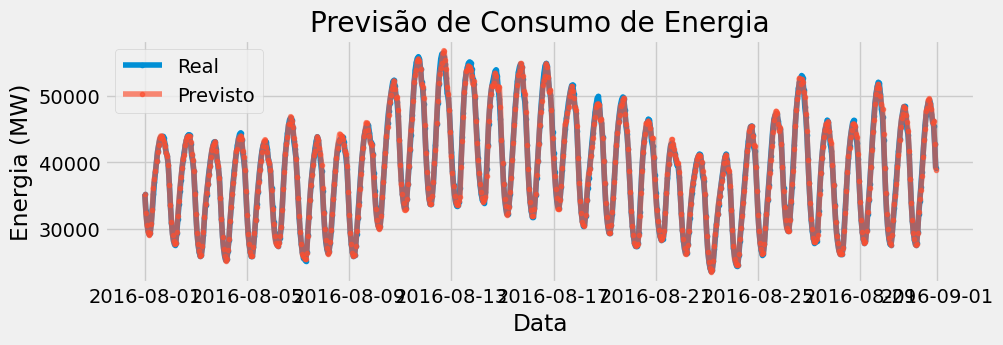

In [218]:
# Converter os arrays numpy para pandas Series com índices datetime
y_test_forecast_series = pd.Series(y_test_forecast, index=X_test.index)
y_pred_final_forecast_series = pd.Series(y_pred_final_forecast, index=X_test.index)

# Filtrar os dados para o intervalo de datas desejado
start_date = '2016-08-01'
end_date = '2016-8-31'

# Filtrar as séries com base nas datas
filtered_y_test_forecast = y_test_forecast_series.loc[start_date:end_date]
filtered_y_pred_final_forecast = y_pred_final_forecast_series.loc[start_date:end_date]

# Plotar os dados filtrados
plt.figure(figsize=(10, 3))
plt.plot(filtered_y_test_forecast.index, filtered_y_test_forecast, label='Real', marker='o', markersize=3)
plt.plot(filtered_y_pred_final_forecast.index, filtered_y_pred_final_forecast, label='Previsto', alpha=0.66, marker='o', markersize=3)
plt.title('Previsão de Consumo de Energia')
plt.xlabel('Data')
plt.ylabel('Energia (MW)')
plt.legend()
plt.show()